
Total samples collected: 584
Class 0: 222 samples
Class 1: 72 samples
Class 2: 105 samples
Class 3: 185 samples


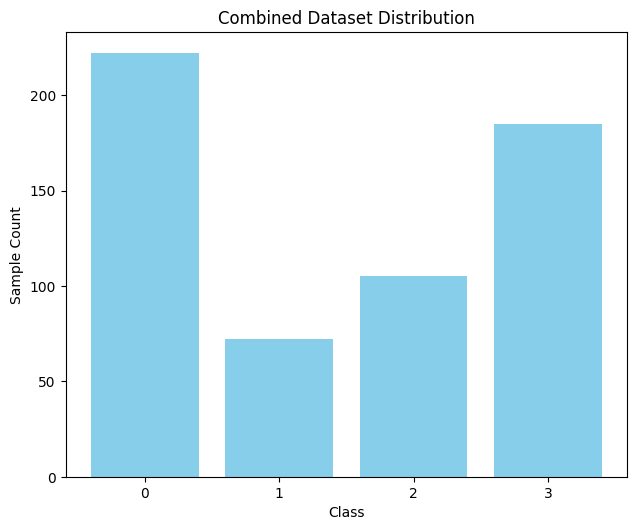


Fold 1/5
Class 0: 37 samples
Class 1: 15 samples
Class 2: 20 samples
Class 3: 45 samples
Fold Accuracy: 0.8718


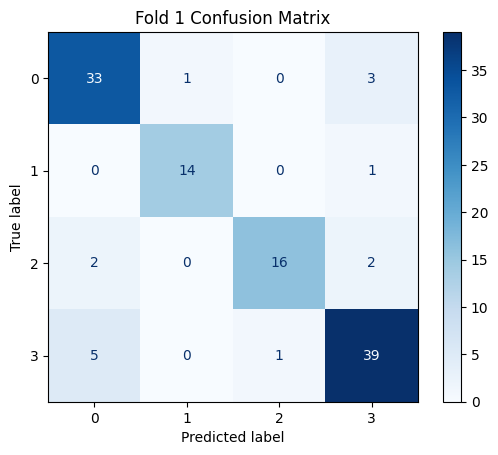


Fold 2/5
Class 0: 53 samples
Class 1: 11 samples
Class 2: 21 samples
Class 3: 32 samples
Fold Accuracy: 0.8974


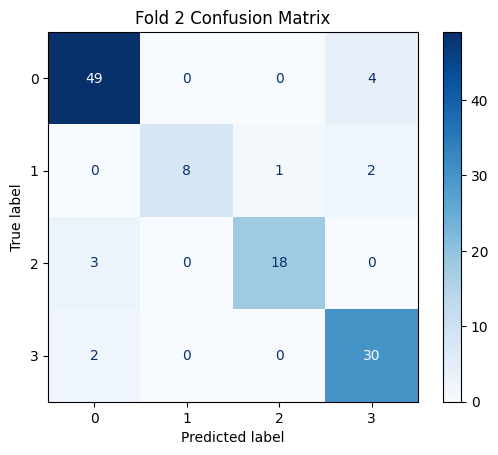


Fold 3/5
Class 0: 44 samples
Class 1: 16 samples
Class 2: 21 samples
Class 3: 36 samples
Fold Accuracy: 0.8974


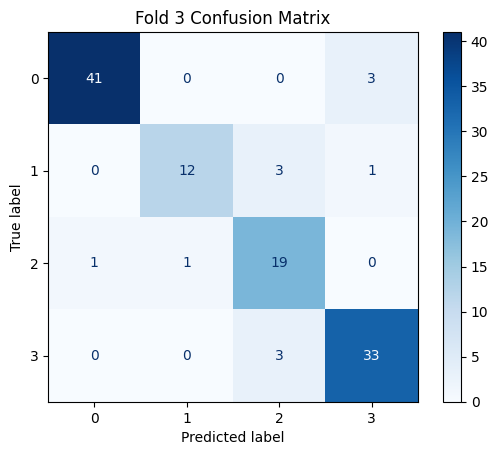


Fold 4/5
Class 0: 37 samples
Class 1: 16 samples
Class 2: 24 samples
Class 3: 40 samples
Fold Accuracy: 0.9145


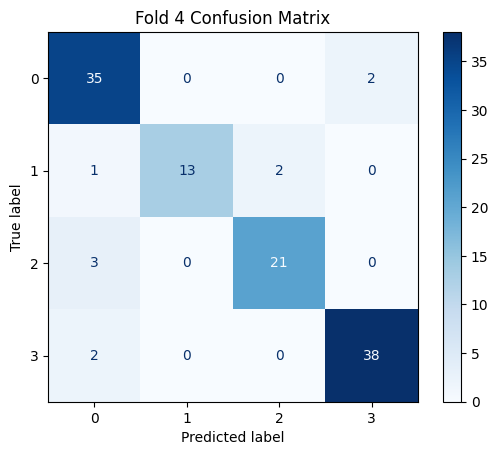


Fold 5/5
Class 0: 51 samples
Class 1: 14 samples
Class 2: 19 samples
Class 3: 32 samples
Fold Accuracy: 0.8793


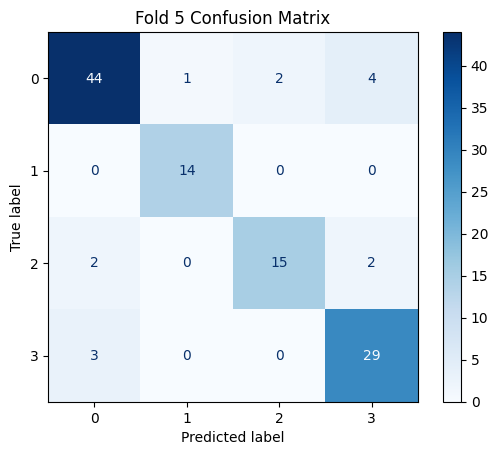


Average Accuracy across 5 folds: 0.8921


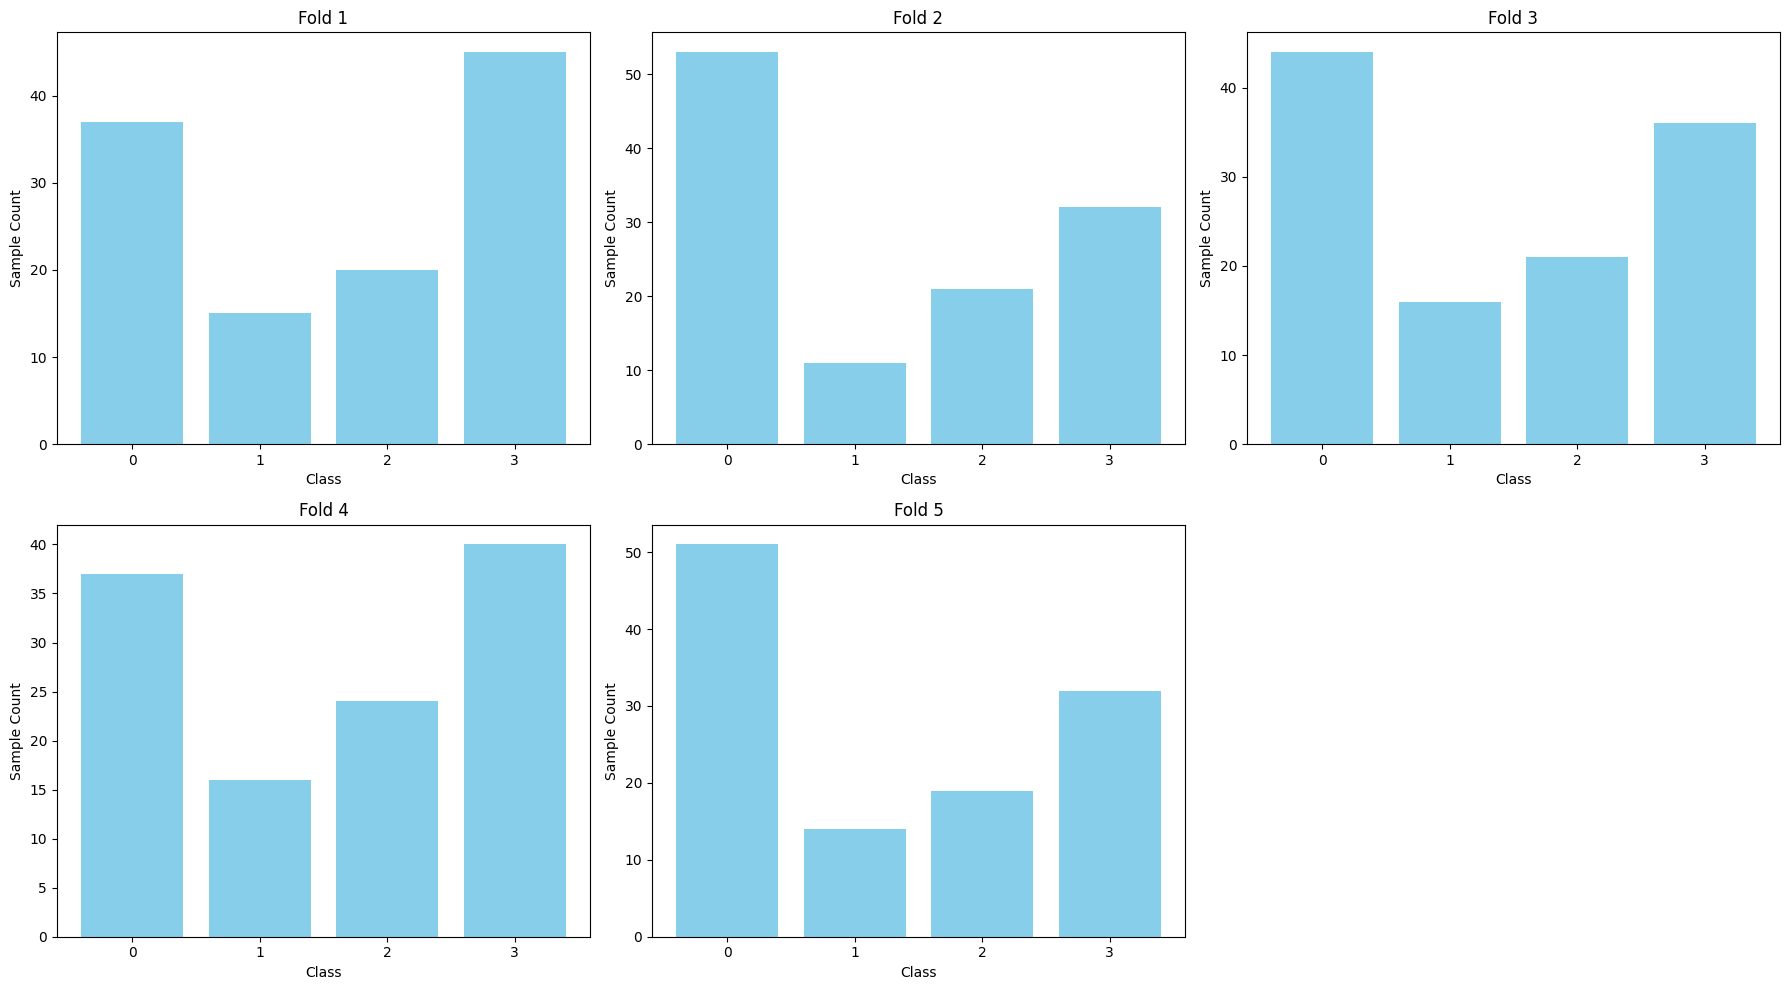

In [1]:
import os
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import timm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --------------------- Dataset ---------------------

class ImageArrayDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, npy_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(np.argmax(np.load(npy_path)))
        return image, label

# --------------------- Sample Aggregation ---------------------

def collect_samples(folder):
    samples = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.png')):
            base = os.path.splitext(fname)[0]
            npy_path = os.path.join(folder, base + '.npy')
            if os.path.exists(npy_path):
                samples.append((os.path.join(folder, fname), npy_path))
    return samples

def count_labels(samples):
    counts = Counter()
    for _, npy_path in samples:
        label = int(np.load(npy_path).argmax())
        counts[label] += 1
    return counts

# --------------------- Plotting ---------------------

def plot_distributions(distributions, titles):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    for i, (label_counts, title) in enumerate(zip(distributions, titles)):
        labels = sorted(label_counts.keys())
        counts = [label_counts.get(l, 0) for l in labels]
        axes[i].bar(labels, counts, color='skyblue')
        axes[i].set_title(title)
        axes[i].set_xlabel("Class")
        axes[i].set_ylabel("Sample Count")
        axes[i].set_xticks(labels)
    for j in range(len(distributions), 6):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

# --------------------- Model Evaluation ---------------------

def load_model(device):
    model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=5).to(device)
    model.load_state_dict(torch.load('vit_tiny_combined_best.pth', map_location=device))
    model.eval()
    return model

def evaluate(model, dataloader, device):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc, all_preds, all_labels

# --------------------- K-Fold Execution ---------------------

def k_fold_evaluation(samples, k=5, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_distributions = []

    for fold, (_, val_idx) in enumerate(kf.split(samples)):
        print(f"\nFold {fold + 1}/{k}")
        val_samples = [samples[i] for i in val_idx]

        val_counts = count_labels(val_samples)
        fold_distributions.append(val_counts)

        for cls in sorted(val_counts):
            print(f"Class {cls}: {val_counts[cls]} samples")

        val_loader = DataLoader(ImageArrayDataset(val_samples, transform),
                                batch_size=batch_size, shuffle=False, num_workers=0)
        model = load_model(device)
        acc, preds, targets = evaluate(model, val_loader, device)
        print(f"Fold Accuracy: {acc:.4f}")
        fold_accuracies.append(acc)

        cm = confusion_matrix(targets, preds)
        ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
        plt.title(f"Fold {fold + 1} Confusion Matrix")
        plt.show()

    avg_acc = sum(fold_accuracies) / k
    print(f"\nAverage Accuracy across {k} folds: {avg_acc:.4f}")
    plot_distributions(fold_distributions, [f"Fold {i+1}" for i in range(k)])

# --------------------- Main ---------------------

if __name__ == "__main__":
    v5 = r"C:\Users\huang\Downloads\Engineering Projects\Genesys Lab\v5"
    v6 = r"C:\Users\huang\Downloads\Engineering Projects\Genesys Lab\v6"

    all_samples = collect_samples(v5) + collect_samples(v6)
    overall_counts = count_labels(all_samples)

    print(f"\nTotal samples collected: {len(all_samples)}")
    for cls in sorted(overall_counts):
        print(f"Class {cls}: {overall_counts[cls]} samples")

    plot_distributions([overall_counts], ["Combined Dataset Distribution"])
    k_fold_evaluation(all_samples, k=5, batch_size=16)


